In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectorMixin
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import load_wine
import warnings
import sklearn, matplotlib
warnings.filterwarnings('ignore')

In [66]:
class OutliersToMedianTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
        self.bounds_ = {}
        self.medians_ = {}

    def fit(self, X, y=None):
        if isinstance(X, np.ndarray):
            if self.features is None:
                raise ValueError("features must be provided when X is ndarray")
            X_df = pd.DataFrame(X, columns=self.features)
        elif isinstance(X, pd.DataFrame):
            X_df = X.copy()
            if self.features is not None:
                missing = set(self.features) - set(X_df.columns)
                if missing:
                    raise ValueError(f"Missing features: {missing}")
                X_df = X_df[self.features]
        else:
            raise ValueError("Input X must be pandas DataFrame or numpy ndarray")
        
        feature_cols = self.features if self.features is not None else X_df.columns
        
        for col in feature_cols:
            if pd.isna(X_df[col]).all():
                warnings.warn(f"Column {col} is all NaN, skipping outlier detection")
                continue
            Q1 = X_df[col].quantile(0.25)
            Q3 = X_df[col].quantile(0.75)
            IQR = Q3 - Q1
            if IQR == 0:
                continue  
            self.bounds_[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
            self.medians_[col] = X_df[col].median()
            
        return self

    def transform(self, X):
    
        check_is_fitted(self, ['bounds_', 'medians_'])
        
        if isinstance(X, np.ndarray):
            if self.features is None:
                raise ValueError("features must be provided when X is ndarray")
            X_df = pd.DataFrame(X, columns=self.features)
        elif isinstance(X, pd.DataFrame):
            X_df = X.copy()
        else:
            raise ValueError("Input X must be pandas DataFrame or numpy ndarray")

        X_df_copy = X_df.copy()
        
        for col in self.bounds_:
            if col in X_df_copy.columns:
                lower, upper = self.bounds_[col]
                mask = (X_df_copy[col] < lower) | (X_df_copy[col] > upper)
                if mask.any():
                    X_df_copy.loc[mask, col] = self.medians_[col]
        return np.asarray(X_df_copy)

In [67]:
class AdvancedFeatureSelector(BaseEstimator, SelectorMixin):

    def __init__(self, variance_percentile=0.10, corr_threshold=0.7, check_stability=True):
        self.variance_percentile = variance_percentile
        self.corr_threshold = corr_threshold
        self.check_stability = check_stability

    def fit(self, X, y=None):

        if y is not None:
            X, y = check_X_y(X, y, ensure_all_finite='allow-nan')
        else:
            X = check_array(X, ensure_all_finite='allow-nan')

        self.n_features_in_ = X.shape[1]

        if hasattr(X, "toarray"):
            X = X.toarray()

        df = pd.DataFrame(X)

        variances = df.var()
        threshold = variances.quantile(self.variance_percentile)
        high_variance_mask = variances > threshold

        if y is not None:
            y_series = pd.Series(y)
            correlations = df.corrwith(y_series).abs().fillna(0)
            high_corr_mask = correlations > self.corr_threshold
        else:
            high_corr_mask = pd.Series(False, index=df.columns)

        stable_mask = pd.Series(True, index=df.columns)

        if self.check_stability:
            from sklearn.model_selection import KFold

            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            stability_scores = []

            for train_idx, _ in kf.split(df):
                stability_scores.append(df.iloc[train_idx].var())

            stability_df = pd.DataFrame(stability_scores)
            stability_std = stability_df.std().fillna(0)

            mean_std = stability_std.mean()
            if mean_std > 0:
                stable_mask = stability_std < (mean_std * 2)

        final_mask = (high_variance_mask | high_corr_mask) & stable_mask
        final_mask = final_mask.fillna(False)

        self.selected_indices_ = np.where(final_mask.values)[0]

        if len(self.selected_indices_) == 0:
            warnings.warn(
                "No features selected; falling back to all features.",
                UserWarning
            )
            self.selected_indices_ = np.arange(self.n_features_in_)

        return self

    def _get_support_mask(self):
        check_is_fitted(self, 'selected_indices_')
        mask = np.zeros(self.n_features_in_, dtype=bool)
        mask[self.selected_indices_] = True
        return mask

    def get_support(self, indices=False):
        check_is_fitted(self, 'selected_indices_')
        if indices:
            return np.array(self.selected_indices_)
        return self._get_support_mask()

    def transform(self, X):
        check_is_fitted(self, 'selected_indices_')

        X = check_array(X, ensure_all_finite='allow-nan')

        if X.shape[1] != self.n_features_in_:
            raise ValueError(
                f"X has {X.shape[1]} features, but {self.n_features_in_} were seen during fit"
            )

        return X[:, self._get_support_mask()]

In [68]:
## Check vsersion
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"matplot version: {matplotlib.__version__}")
print(f"sklearn version: {sklearn.__version__}")


numpy version: 2.3.3
pandas version: 2.3.3
seaborn version: 0.13.2
matplot version: 3.10.7
sklearn version: 1.7.2


In [69]:
## Clean Dataset
def clean_dataset(col):
    col = col.strip().lower()
    col = re.sub(r'[\^]', "_", col)
    col = col.strip("_")
    return col

In [70]:
## Load Dataset
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target
df.columns = [clean_dataset(col) for col in df.columns]

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [72]:
df.shape

(178, 14)

In [73]:
## check duplicate values
df.duplicated().sum()

np.int64(0)

In [74]:
X = df.drop(df[["target"]], axis=1)
Y = df["target"]

In [75]:
df1 = X.join(Y)
df1.sample(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
140,12.93,2.81,2.70,21.0,96.0,1.54,0.50,0.53,0.75,4.6,0.77,2.31,600.0,2
151,12.79,2.67,2.48,22.0,112.0,1.48,1.36,0.24,1.26,10.8,0.48,1.47,480.0,2
33,13.76,1.53,2.70,19.5,132.0,2.95,2.74,0.50,1.35,5.4,1.25,3.00,1235.0,0


In [76]:
## Split data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [77]:
type(X_train)

pandas.core.frame.DataFrame

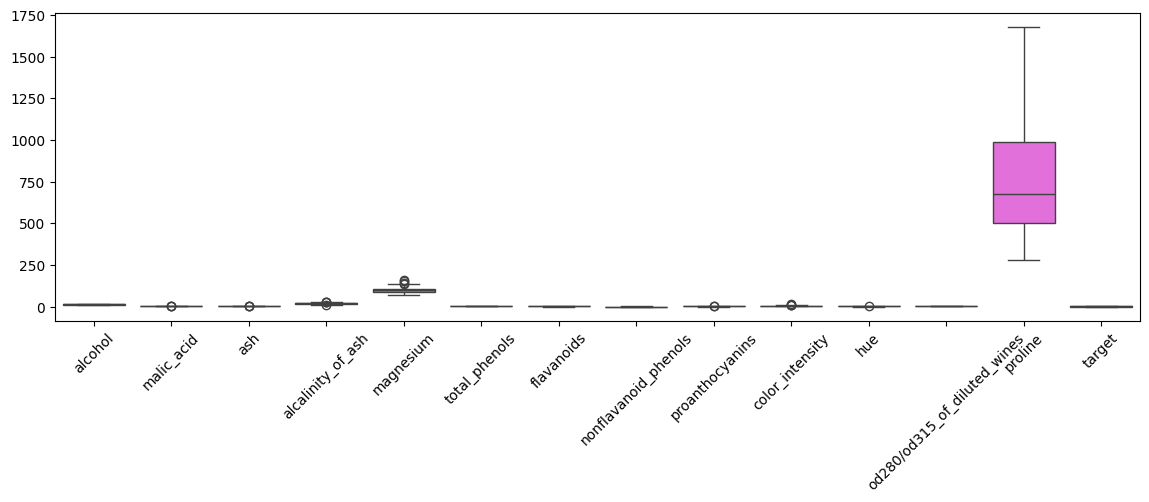

In [78]:
## Visualize Oultliers
plt.figure(figsize=(14, 4))
sns.boxplot(df.select_dtypes(np.number))
plt.xticks(rotation=45)
plt.show()

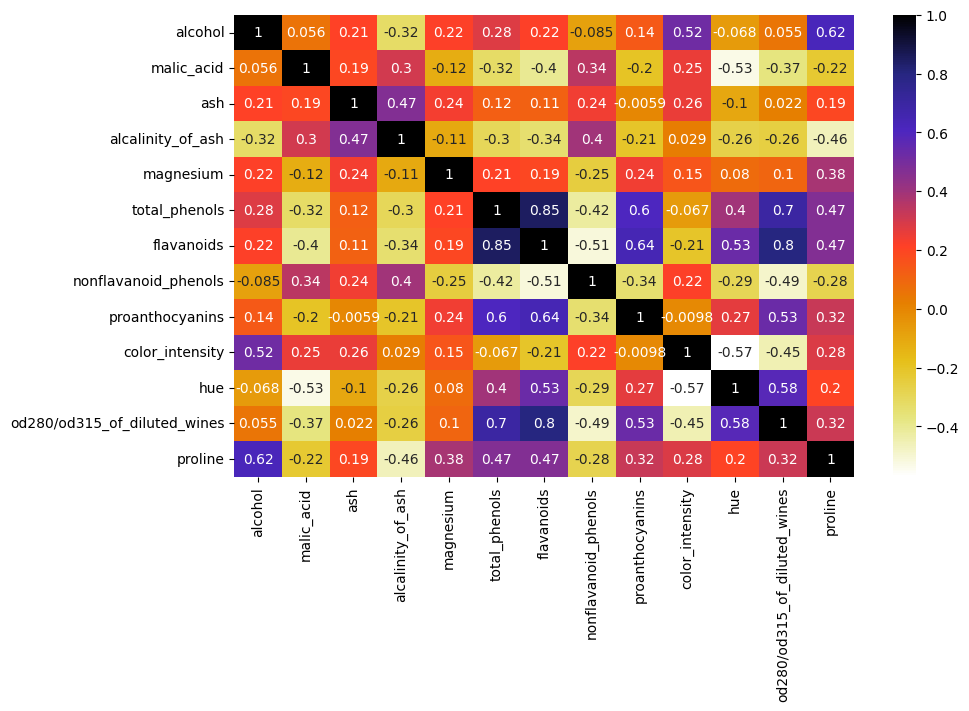

In [80]:
## Visualize Correlation
plt.figure(figsize=(10, 6))
corr = X_train.corr()
sns.heatmap(data=corr, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()


In [81]:
numerical_cols = X_train.select_dtypes(np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

In [82]:
skewness = X_train[numerical_cols].apply(lambda x:x.skew())
skew_threshold = 0.6

In [83]:
skew_cols = skewness[skewness >= skew_threshold].index.tolist()
norm_cols = list(set(numerical_cols) - set(skew_cols))

In [84]:
skew_cols

['malic_acid', 'magnesium', 'proanthocyanins', 'color_intensity', 'proline']

<Figure size 1600x1200 with 0 Axes>

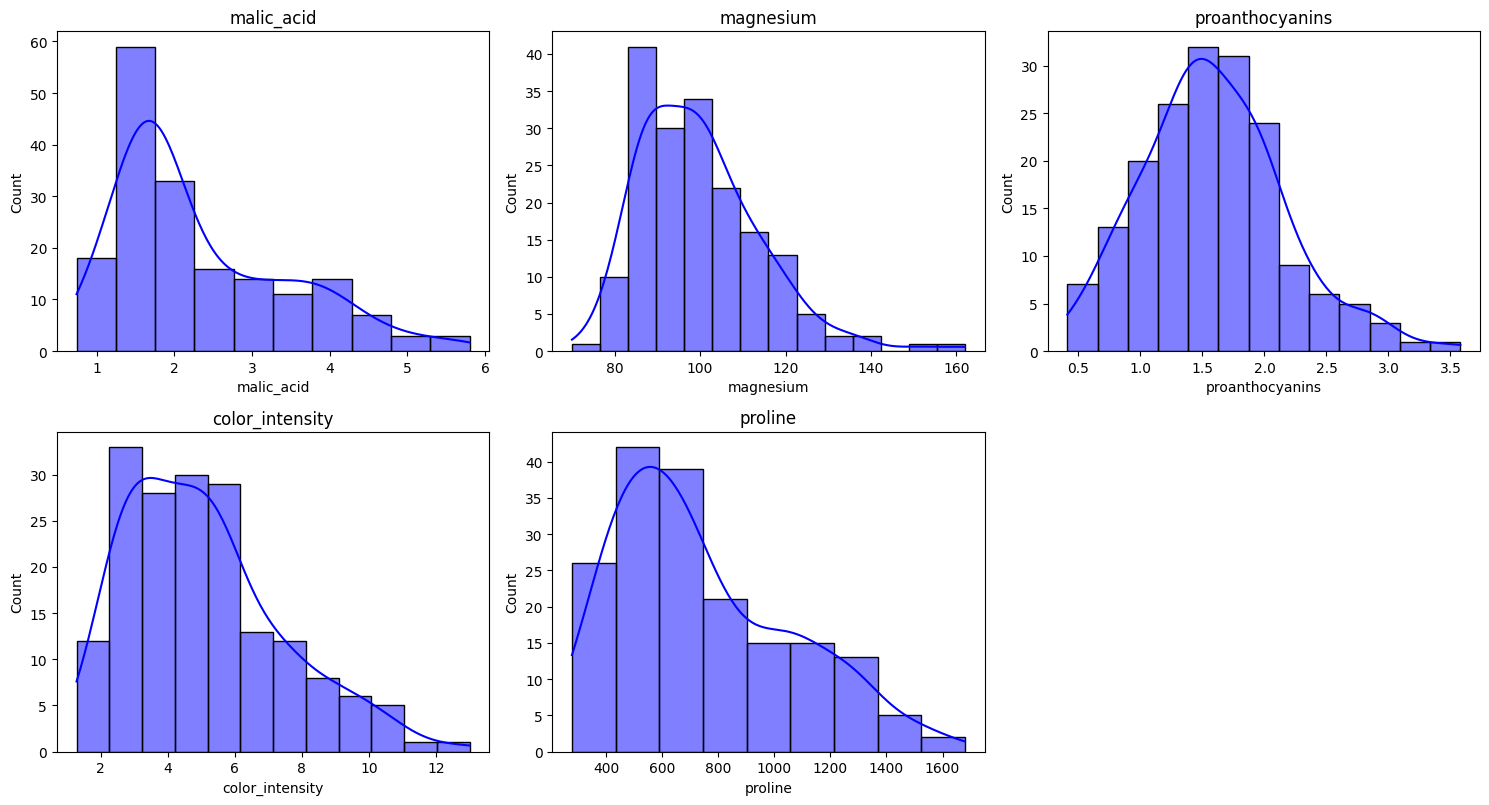

In [85]:
import math
df = df[['malic_acid', 'magnesium', 'proanthocyanins', 'color_intensity', 'proline']]
new_df = df.apply(lambda x: x**2)
plt.figure(figsize=(16, 12))
cols = new_df
total = len(cols)
rows = math.ceil(total/3)
plt.figure(figsize=(15, rows*4))


for i, col in enumerate(cols, 1):
    plt.subplot(rows, 3, i)
    sns.histplot(df[col], kde=True, color="blue")
    plt.title(col)
plt.tight_layout()
plt.show()

In [86]:
skew_subpipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log1p', FunctionTransformer(np.log1p)),
    ('SS', StandardScaler())
])

In [87]:
norm_subpipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('MMS', MinMaxScaler())
])

In [88]:
cat_subpipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OHE', OneHotEncoder(handle_unknown='ignore'))
])

In [89]:
preprocessor = ColumnTransformer([
    ('skew', skew_subpipeline, skew_cols),
    ('norm', norm_subpipeline, norm_cols),
    ('cat', cat_subpipeline, categorical_cols)
], remainder='drop')

In [90]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Feature_selection', AdvancedFeatureSelector(variance_percentile=0.10, corr_threshold=0.5)),
    ('LogisticRegression', LogisticRegression())
    # ('DTC', DecisionTreeClassifier(max_depth=5, max_features=10, min_samples_leaf=30))
])

In [91]:
## Training Base Befor fitting model
print("==== Training Base Model ====")
final_pipeline.fit(X_train, Y_train)
y_pred = final_pipeline.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
print(f"Base Model Accuracy: {acc * 100:.2f}%")

==== Training Base Model ====
Base Model Accuracy: 100.00%


In [92]:
final_pipeline.fit(X_train, Y_train)

,steps,"[('preprocessor', ...), ('Feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('skew', ...), ('norm', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [93]:
print("Model accuracy: ", final_pipeline.score(X_train, Y_train)*100)

Model accuracy:  93.66197183098592


In [94]:
X_test.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

In [95]:
# Cross-validation confirms generalization
scores = cross_val_score(final_pipeline, X, Y, cv=5)
print(f"CV Scores: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = final_pipeline.predict(X_test)
print(confusion_matrix(Y_test, y_pred))


CV Scores: 0.9105 (+/- 0.1375)
[[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]


In [96]:
import cloudpickle
cloudpickle.dump(final_pipeline, open('wine.pkl', 'wb'))